# 制御用関数の再発明

趣味で制御用の関数を作って、モータの制御などを考察しようとしています。

車輪の再発明系ですね（笑）

## よく使うモジュールのインポート

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

## 伝達関数を定義する関数
numpyの多項式関数poly1d()を駆使して、伝達関数を定義する関数を作ってみました。

分母と分子の共通の極については約分する機能付きです。

In [176]:
def tf(num,den):
    
    num=np.poly1d(num)
    den=np.poly1d(den)
    
    z=num.r
    p=den.r

    zz=z
    pp=p
    
    #分母分子から共通の極を見つけ出して削除する
    for x in z:
        pp=pp[~np.isclose(pp,x)]

    for x in p:
        zz=zz[~np.isclose(zz,x)]

    num=np.poly1d(zz, r=True, variable = "s")*num.coef[0]
    den=np.poly1d(pp, r=True, variable = "s")*den.coef[0]

    return [num, den]

## 伝達関数の演算用関数

制御系を設計したり解析したりするために伝達関数を結合したり、掛け合わせたり、逆数をとったりして
開ループ伝達関数や閉ループ伝達関数を作り出すための演算よう関数群

In [177]:
def tf_add(sys1, sys2):
    num=sys1[0]*sys2[1]+sys1[1]*sys2[0]
    den=sys1[1]*sys2[1]
    return  tf(num.coef, den.coef)


def tf_multi(sys1, sys2):
    num=sys1[0]*sys2[0]
    den=sys1[1]*sys2[1]
    return tf(num.coef, den.coef)

def tf_inv(sys):
    return tf(sys[1].coef, sys[0].coef)

## 伝達関数表示用関数

これは思いっきりショボいです。変数がsではなくxででます。

時間があったら改善したいですが、優先順位は低いです。

In [178]:
def tf_print(sys):
    print(sys[0])
    print('---------------------')
    print(sys[1])

## ステップ応答計算用関数

単位ステップ応答を計算します。

ヘビサイドの展開定理の自分なりの実装です。

In [182]:
def step(sys,st,et,step=1000, debug=False):

    n=len(sys[1])
    p=sys[1].r
    if debug==True:
        print('order={}'.format(n))
        print('Pole={}'.format(p))
    
    y=np.zeros(step)
    t=np.linspace(st, et, step)

    for i in range(n):
        k=sys[0](p[i])/sys[1].deriv()(p[i])/p[i]
        
        if debug==True:
            print('k{}={}'.format(i+1,k))

        y=y+(k*np.exp(p[i]*t)).real
    
    k=sys[0](0)/sys[1](0)
    if debug==True:
        print('k{}={}'.format(i+2,k))

    y=y+k
    
    return t,y    

## 単位ランプ応答計算用関数

単位ランプ応答を計算します。

ヘビサイドの展開定理の自分なりの実装です。

In [183]:
def ramp(sys,st,et,step=1000, debug=False):

    n=len(sys[1])
    p=sys[1].r
    if debug==True:
        print('order={}'.format(n))
        print('Pole={}'.format(p))
    
    y=np.zeros(step)
    t=np.linspace(st, et, step)

    for i in range(n):
        k=sys[0](p[i])/sys[1].deriv()(p[i])/p[i]/p[i]
        
        if debug==True:
            print('k{}={}'.format(i+1,k))

        y=y+(k*np.exp(p[i]*t)).real
    
    k=sys[0](0)/sys[1](0)
    if debug==True:
        print('k{}={}'.format(i+2,k))

    y=y+k*t
    
    k=(sys[0].deriv()(0)*sys[1](0)-sys[0](0)*sys[1].deriv()(0))/(sys[1](0))**2
    if debug==True:
        print('k{}={}'.format(i+3,k))
    
    y=y+k
    
    return t,y    

## 計算サンプル
以降は計算のサンプルです

### １次遅れシステムのステップ応答

order=1
Pole=[-1.]
k1=-1.0
k2=1.0


<IPython.core.display.Javascript object>


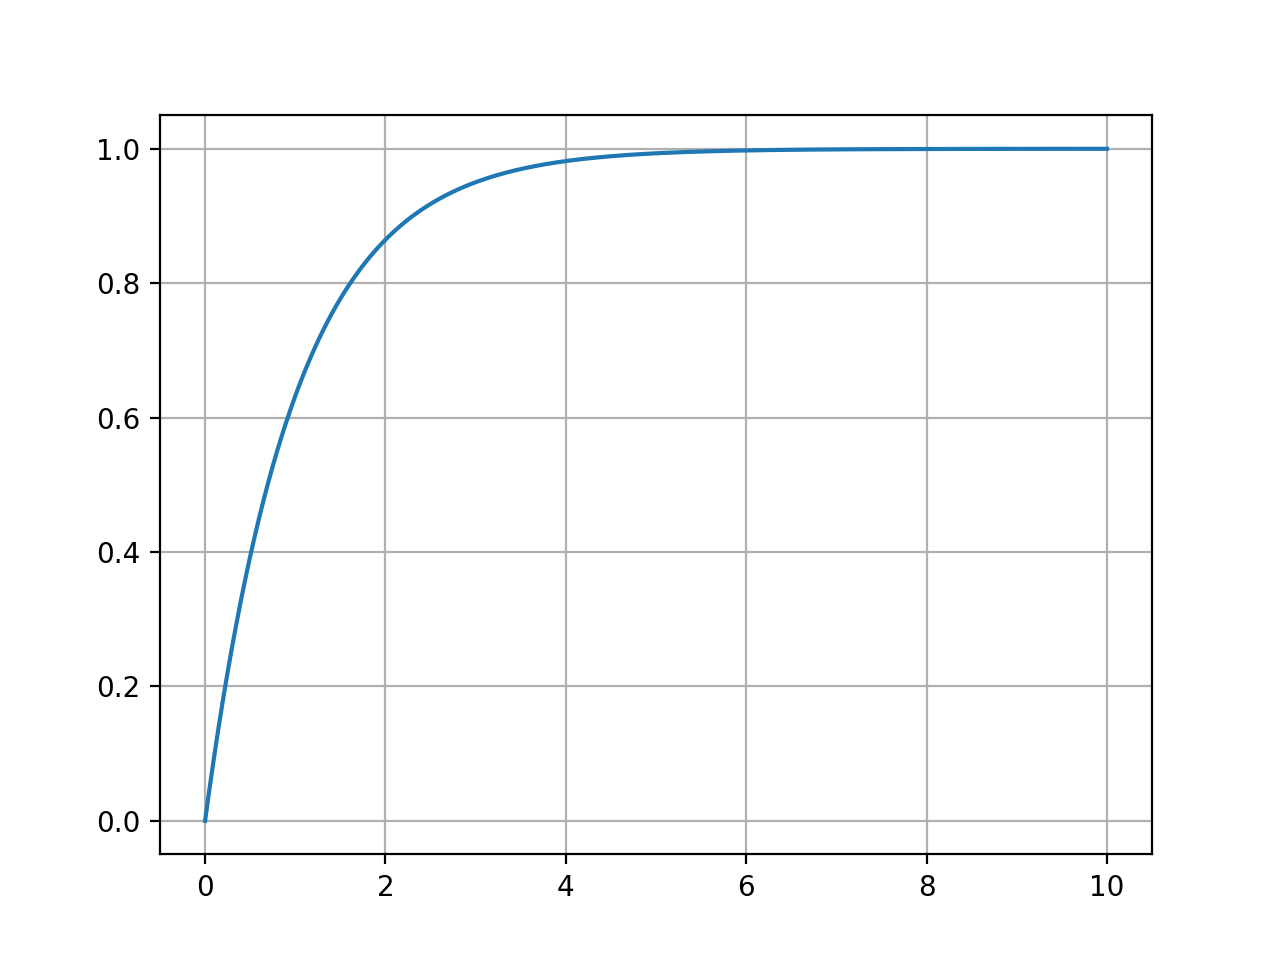

In [185]:
sys=tf([1],[1, 1])
t,y=step(sys,0, 10, debug=True)
plt.plot(t,y)
plt.grid()
plt.show()

### ２次振動系のステップ応答

order=2
Pole=[-1.88495559+5.99377677j -1.88495559-5.99377677j]
k1=(-0.5+0.15724272550828775j)
k2=(-0.5-0.15724272550828775j)
k3=1.0


<IPython.core.display.Javascript object>


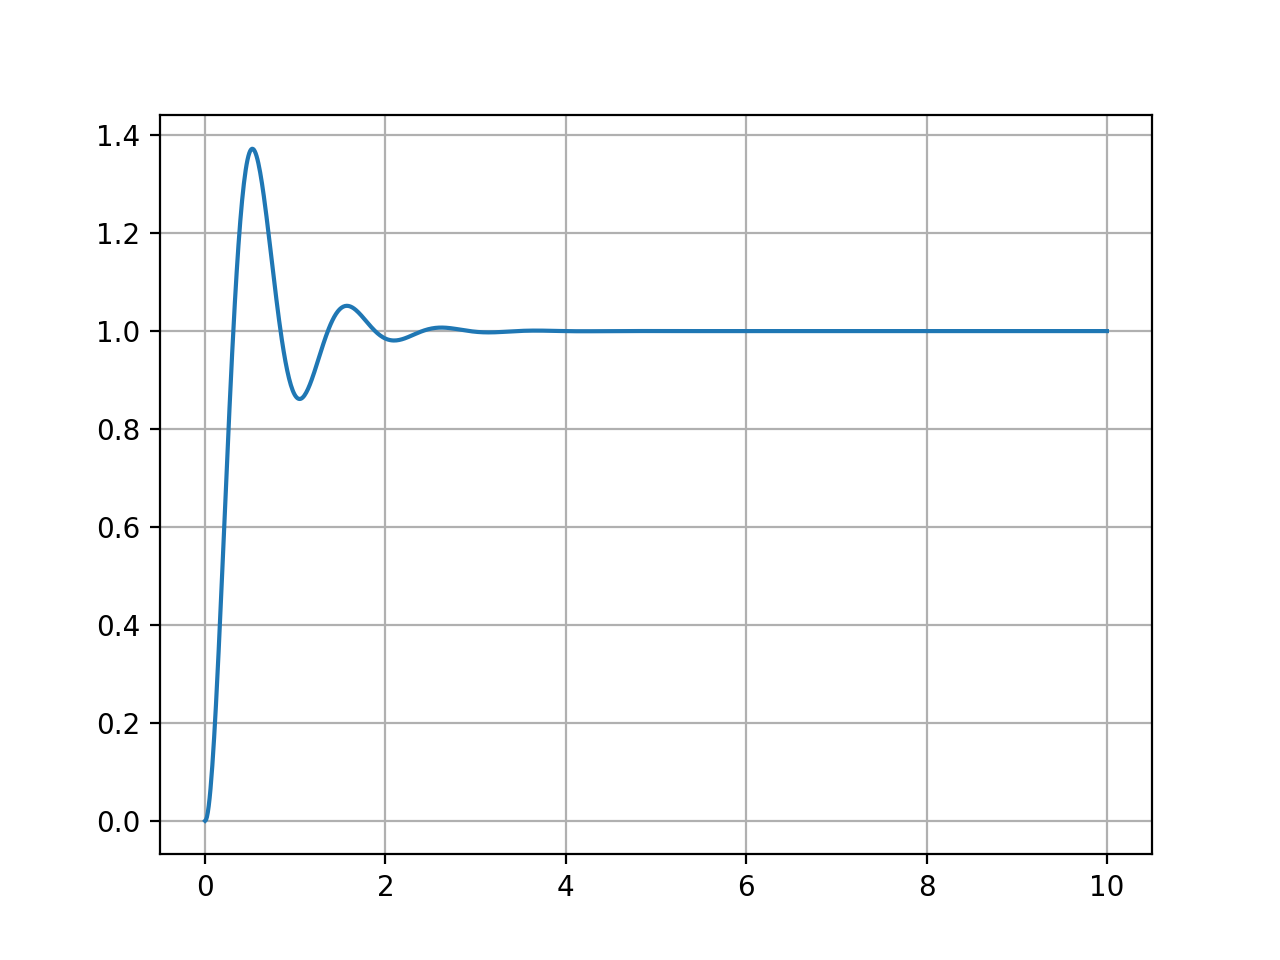

In [208]:
z=0.3
omega=2*np.pi

sys=tf([0,omega**2],[1, 2*z*omega, omega**2])
t,y=step(sys,0, 10, debug=True)

plt.plot(t,y)
plt.grid()
plt.show()

### １次遅れシステムのランプ応答

order=1
Pole=[-1.]
k1=1.0
k2=1.0
k3=-1.0


<IPython.core.display.Javascript object>


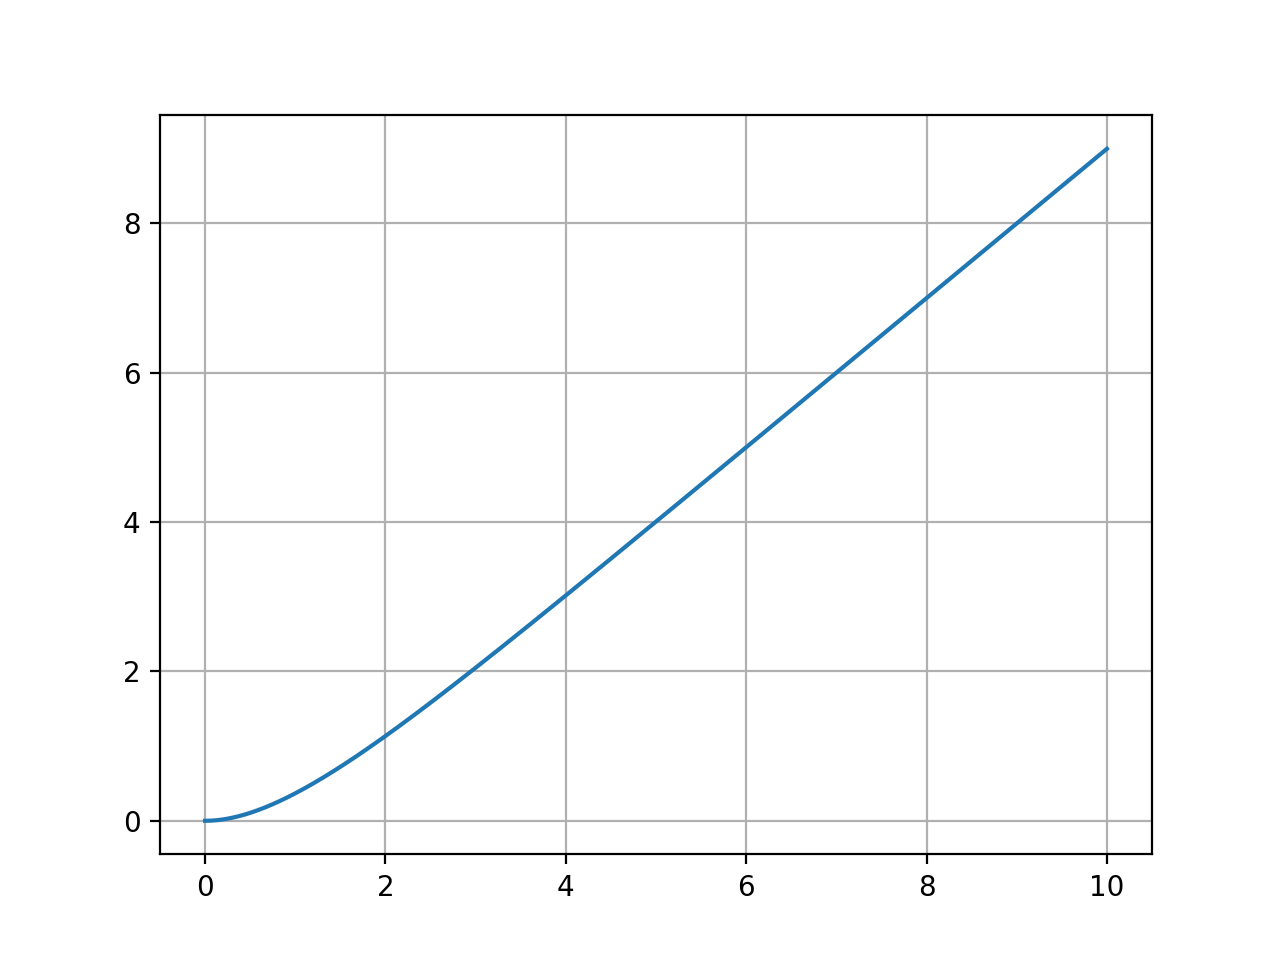

In [186]:
sys=tf([1],[1, 1])
t,y=ramp(sys,0, 10, debug=True)
plt.plot(t,y)
plt.grid()
plt.show()

### DCモータ、PI制御器、１の伝達関数の生成
伝達要素を必ず分母分子がある形にしなければならないので定数要素の表現が不自然です。改善事項です。

In [187]:
#1724DCモータの諸元
R=3.41
K=6.59e-3
L=75e-6
D=1.4e-7
J=1e-7

kp=0.1
ki=10

motor=tf([0,K],[J*L, D*L+J*R, D*R+K**2])
cont=tf([kp, ki],[1, 0])
one=tf([0,1],[0,1])
print(motor)
print(cont)
print(one)

[poly1d([0.00659]), poly1d([7.500000e-12, 3.410105e-07, 4.390550e-05])]
[poly1d([ 0.1, 10. ]), poly1d([1., 0.])]
[poly1d([1.]), poly1d([1.])]


### DCモータのステップ応答

order=2
Pole=[-45338.94883714   -129.11782952]
k1=0.4286667719668313
k2=-150.52375736426163
k3=150.09509059229478


<IPython.core.display.Javascript object>


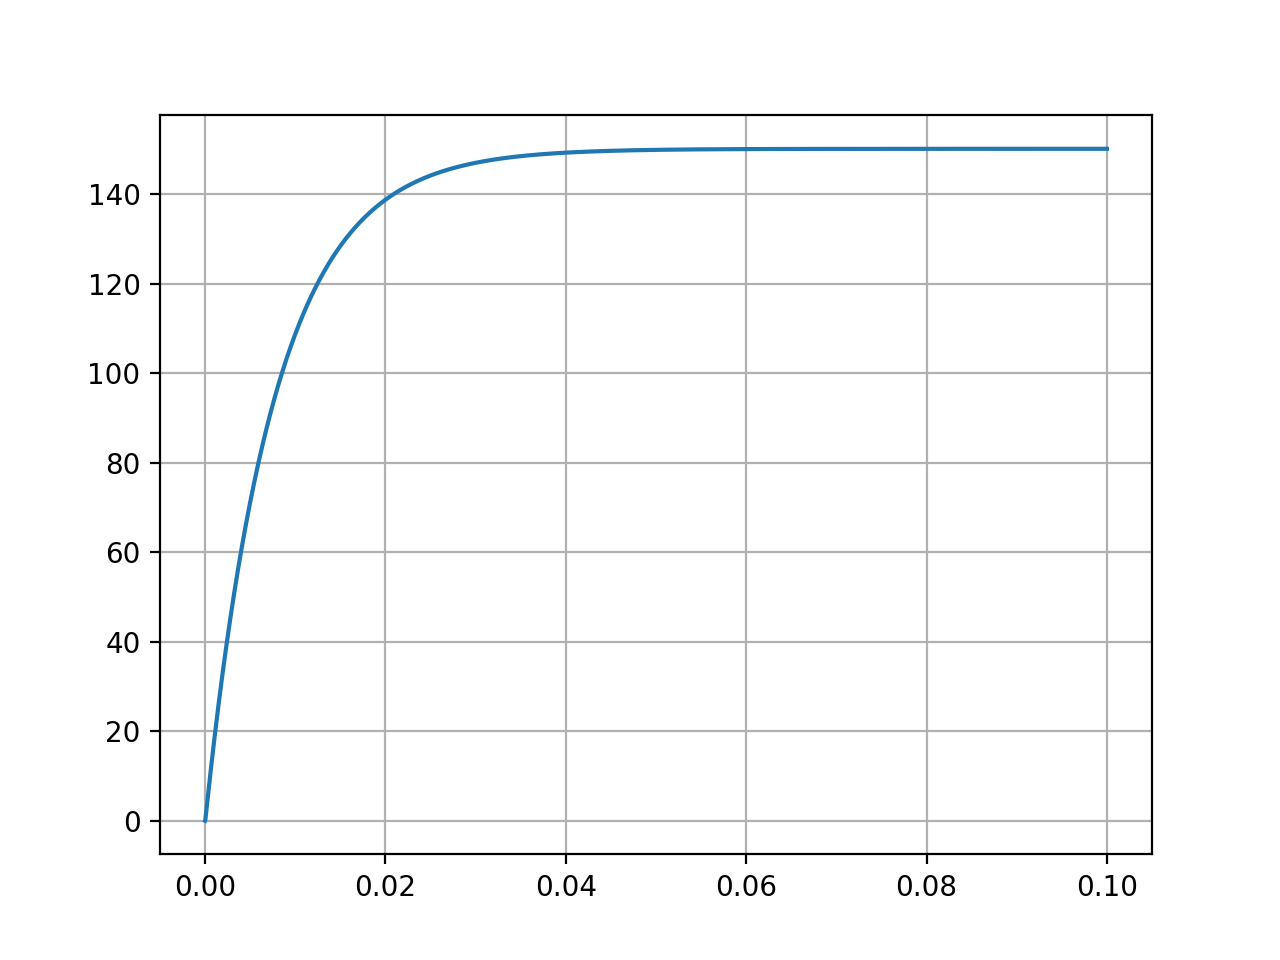

In [192]:
t,y=step(motor,0, 0.1, step=10000, debug=True)

plt.plot(t,y)
plt.grid()
plt.show()

### PI制御閉ループ伝達関数の計算

In [191]:
sys_num=tf_multi(cont,motor)
sys_den=tf_add(one, tf_multi(cont,motor))
motor_pi_control=tf_multi(sys_num, tf_inv(sys_den))
print(motor_pi_control)

[poly1d([4.9425e-15, 4.9425e-13]), poly1d([5.62500000e-23, 2.55757875e-18, 5.27179125e-15, 4.94250000e-13])]


### DCモータのPI制御系のステップ応答

order=3
Pole=[-43308.73679798  -2060.88457336    -98.44529533]
k1=0.04918488593736748
k2=-1.032820727876966
k3=-0.016364158060413938
k4=1.0000000000000129


<IPython.core.display.Javascript object>


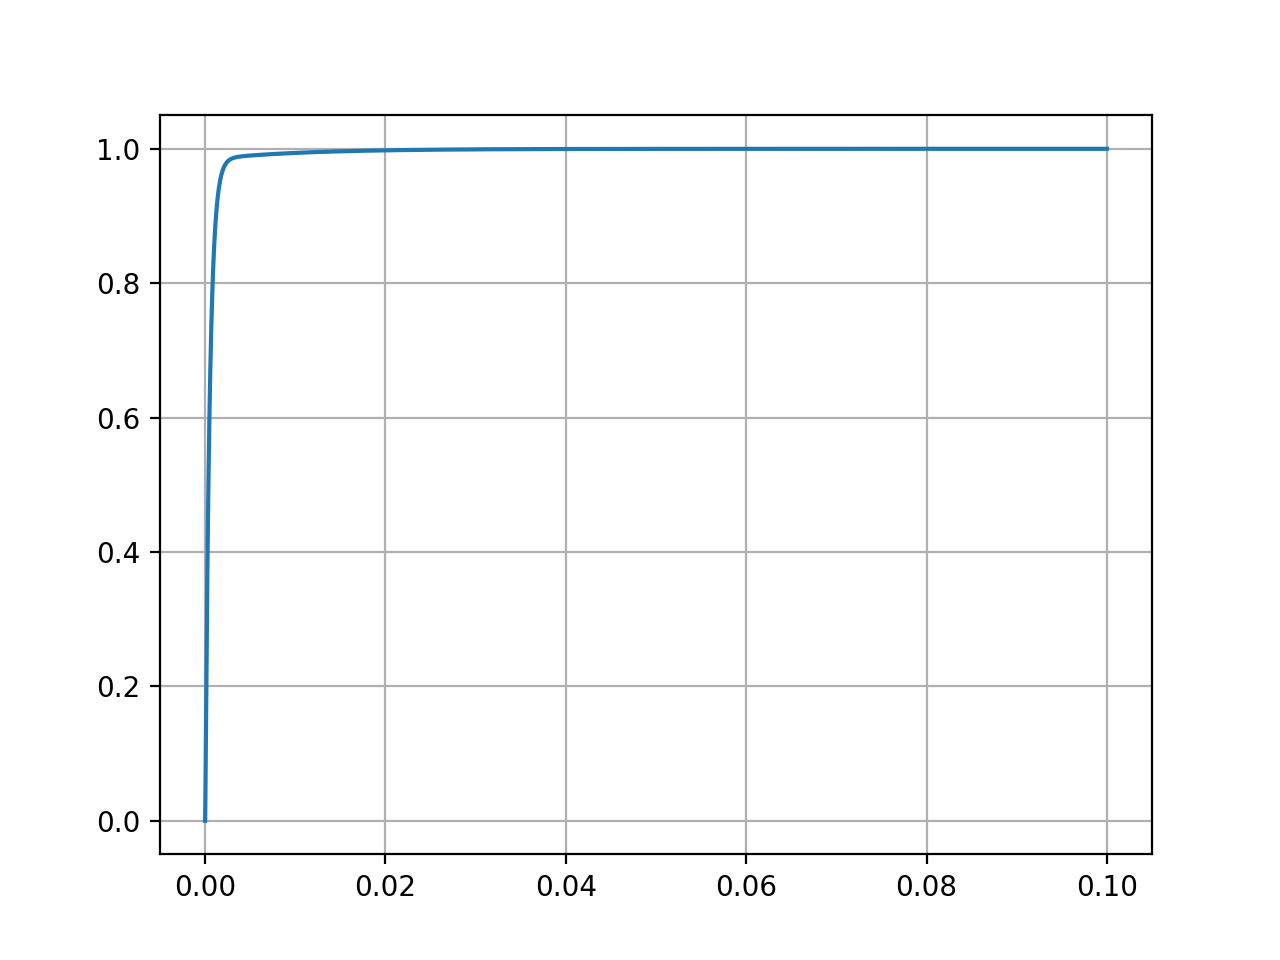

In [193]:
t,y=step(motor_pi_control,0, 0.1, step=10000, debug=True)

plt.plot(t,y)
plt.grid()
plt.show()

### 解析的に解いた伝達関数との比較
以下はて計算で伝達関数を求めた結果と今回作った関数で算出した伝達関数両方で計算した結果の比較です。

一致しました。

In [195]:
#閉ループ伝達関数の分子と分母

Dcom=np.poly1d([J*L, D*L+J*R, D*R+K**2+K*kp, K*ki])
No=np.poly1d([K*kp, K*ki])

mot_pi=tf([K*kp, K*ki], [J*L, D*L+J*R, D*R+K**2+K*kp, K*ki])


order=3
Pole=[-43308.73679798  -2060.88457336    -98.44529533]
k1=0.04918488593736748
k2=-1.032820727876966
k3=-0.016364158060413938
k4=1.0000000000000129
order=3
Pole=[-43308.73679798  -2060.88457336    -98.44529533]
k1=0.049184885937367355
k2=-1.0328207278769626
k3=-0.016364158060403866
k4=1.0000000000000004


<IPython.core.display.Javascript object>


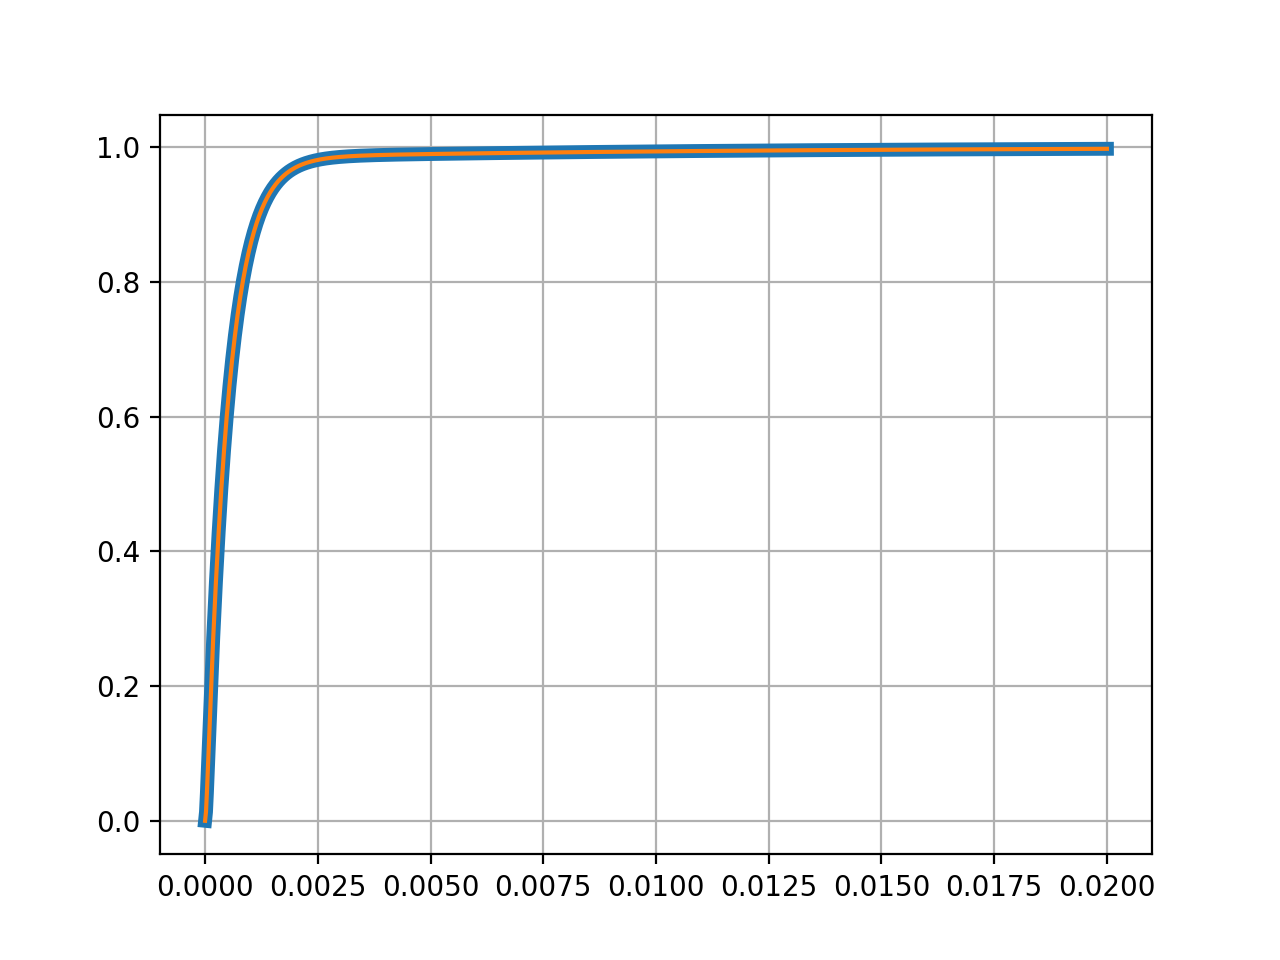

In [200]:
t,y1=step(motor_pi_control,0, 0.02, step=1000, debug=True)
t,y2=step(mot_pi,0, 0.02, step=1000, debug=True)

plt.plot(t,y1,linewidth=5)
plt.plot(t,y2)

plt.grid()
plt.show()

### DCモータのランプ応答

order=3
Pole=[-43308.73679798  -2060.88457336    -98.44529533]
k1=-1.1356804555809423e-06
k2=0.0005011540875350965
k3=0.0001662259024805328
k4=1.0000000000000129
k5=-0.0006662443095600539


<IPython.core.display.Javascript object>


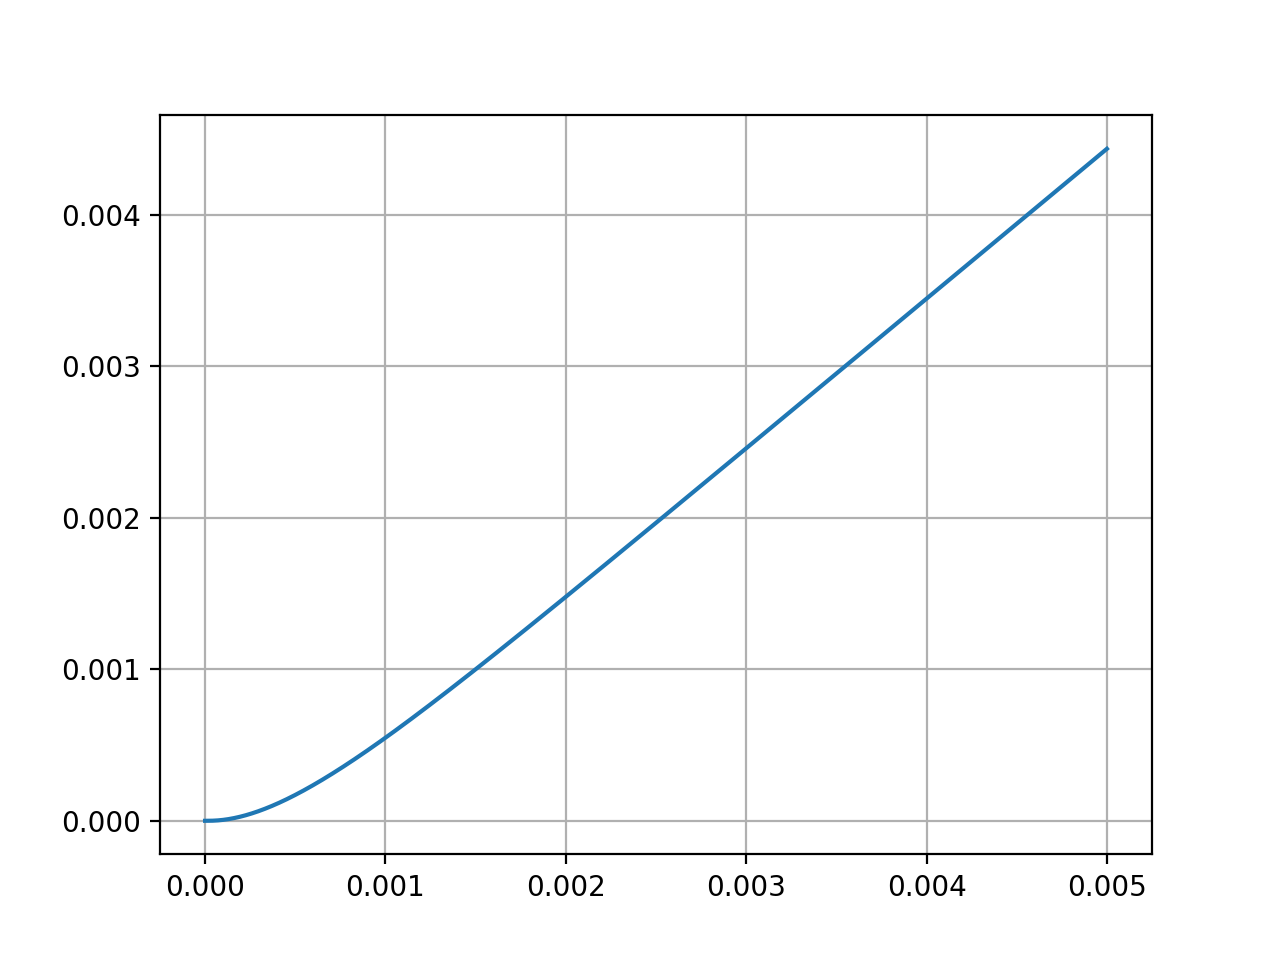

In [207]:
t,y=ramp(motor_pi_control,0, 0.005, step=10000, debug=True)

plt.plot(t,y)
plt.grid()
plt.show()